In [1]:
#!pip install git+https://github.com/alan-turing-institute/SigNet.git
# !pip install --upgrade matplotlib
#!python -m pip install basemap

In [1]:
%matplotlib inline
from SBM_attributed import *
from BregmanFramework import *
from copy import deepcopy
from sklearn.metrics import rand_score, calinski_harabasz_score, mutual_info_score, accuracy_score
from signet.cluster import Cluster
import scipy.sparse as ss
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.cluster import KMeans
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigs

In [2]:
c = 3
n = 100
N = c*n
delta = 10
d = 2
dim = c*d
P = np.array([[0.8, 0.2, 0.3],[0.2, 0.7, 0.4],[0.3, 0.4, 0.6]])
true_labels = [0]*n + [1]*n + [2]*n

In [3]:
### Generate benchmark
_,A,X = generate_benchmark(np.ones((c,c))*0.1,c,delta=0,n=n,dim=d,sample_along_direction=True,P_data=P)
A = torch.tensor(A,dtype=torch.float32)
X = torch.tensor(X,dtype=torch.float32)

In [4]:
classifier = BregmanClustering(norm=-np.inf,matrix_norm=False,method='hard')
W,B,mu=classifier.cluster(A,X,c,maxiter=2,threshold=10)

point assignments have converged


In [6]:
pred_labels = np.argmax(W, axis=1)
true_labels = [0]*n + [1]*n + [2]*n
print(rand_score(true_labels, pred_labels),mutual_info_score(true_labels, pred_labels))

0.5573021181716834 0.008363006512813909


In [5]:
W = torch.tensor(W)
Z=W/W.sum(dim=0)
Z.T@A@Z

tensor([[0.1190, 0.1047, 0.1009],
        [0.1047, 0.1059, 0.0921],
        [0.1009, 0.0921, 0.0900]])

In [6]:
pred_label = spectral(A.detach().numpy(),c)
print(rand_score(true_labels, pred_labels),mutual_info_score(true_labels, pred_labels))

NameError: name 'spectral' is not defined

In [10]:
pout_min = 0.01
pout_max = 0.08
pin=0.1
#pouts = np.arange(pout_min,pout_max,0.01)
pouts=[0.01,0.05,0.1]
deltas=[0.1,1,10]
with open("metrics.txt",'w',encoding = 'utf-8') as f:
    f.write("pout,pout_data,delta,RandIndex,StdRand,MutualInfo,StdMutual\n")
    for p_net in pouts:
        P_net = np.eye(3)*pin
        P_net[P_net==0] = p_net
        for p_data in pouts:
            rs = []
            mi = []
            P_data = np.eye(3)*pin
            P_data[P_data==0] = p_data
            for _ in range(10):
                _,A,X = generate_benchmark(P_net,c,delta=,n=n,dim=d,sample_along_direction=True,P_data=P_data)
                A = torch.tensor(A,dtype=torch.float32)
                X = torch.tensor(X,dtype=torch.float32)
                classifier = BregmanClustering(norm=2,matrix_norm=False,method='hard')
                W,B,mu=classifier.cluster(A,X,c,maxiter=100,threshold=5)
                pred_labels = np.argmax(W, axis=1)
                rs.append(rand_score(true_labels, pred_labels))
                mi.append(mutual_info_score(true_labels, pred_labels))
            f.write(f"{pout},{pout_data},{delta},{np.mean(rs)},{np.std(rs)},{np.mean(mi)},{np.std(mi)}\n")

point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assi

In [11]:
rs = []
mi = []
half_n = int(n/2)
true_labels = [0]*half_n + [1]*half_n + [2]*half_n + [0]*half_n + [1]*half_n + [2]*half_n
for _ in range(10):
    P = np.eye(3)*pin
    P[P==0] = pin
    _,A,X = generate_benchmark(P,c,delta=10,n=n,dim=d,sample_along_direction=True)
    A = torch.tensor(A,dtype=torch.float32)
    X = torch.tensor(X,dtype=torch.float32)
    P = np.eye(3)*pin
    P[P==0] = pin/10
    _,A2,X2 = generate_benchmark(P,c,delta=0.1,n=half_n,dim=d,sample_along_direction=True)
    A[half_n*c:,half_n*c:],X[half_n*c:,:] = torch.tensor(A2,dtype=torch.float32),torch.tensor(X2,dtype=torch.float32)
    classifier = BregmanClustering(norm=1,matrix_norm=False,method='hard')
    W,B,mu=classifier.cluster(A,X,c,maxiter=100,threshold=5)
    pred_labels = np.argmax(W, axis=1)
    rs.append(rand_score(true_labels, pred_labels))
    mi.append(mutual_info_score(true_labels, pred_labels))
print(f"{pout,delta,np.mean(rs)},{np.std(rs)},{np.mean(mi)},{np.std(mi)}\n")

point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
(0.1, 10, 0.5610055741360089),0.043307938922367346,0.1455406481992696,0.1496228814753937



In [14]:
df = pd.read_csv("metrics.txt")

In [15]:
df

,pout,delta,RandIndex,StdRand,MutualInfo,StdMutual
0,0.01,0.1,0.553996,0.002944,0.005807,0.003198
1,0.01,1.0,0.675525,0.074696,0.283466,0.166360
2,0.01,10.0,0.868428,0.104595,0.814644,0.219550
3,0.05,0.1,0.556045,0.001805,0.006372,0.003702
4,0.05,1.0,0.626118,0.037217,0.171020,0.083236
5,0.05,10.0,0.806878,0.068193,0.694162,0.139063
6,0.10,0.1,0.555525,0.001504,0.004905,0.002621
7,0.10,1.0,0.634553,0.053059,0.187802,0.120929
8,0.10,10.0,0.915313,0.115635,0.937672,0.202744


## Australia Rainfall 

In [6]:
corr_df=pd.read_csv('data/corr_mat.csv',index_col=0)
stat_lat_lon_df = pd.read_csv('data/stations_coords.csv')
stat_lat_lon_df = stat_lat_lon_df.drop(stat_lat_lon_df.columns[[0]],axis=1)
# Create the signed graph 
corr=corr_df.to_numpy()
# Adjacency matrices (positive and negative)
Ap = (corr + abs(corr))/2.
Am = (abs(corr)- corr)/2.
Aps = ss.csc_matrix(Ap)
Ams = ss.csc_matrix(Am)
# Covariates
X = np.array(stat_lat_lon_df,dtype=float)

In [7]:
m = Cluster((Aps, Ams))
k=5
predictions = m.SPONGE(k, tau_p=1, tau_n=1, eigens=None, mi=None)
classifier = BregmanClustering(norm=-np.inf,matrix_norm=False,method='hard')
W,B,mu=classifier.cluster(torch.tensor(Ap-Am,dtype=torch.float),torch.tensor(X,dtype=torch.float),k,maxiter=2,threshold=5)
predictions2 = np.argmax(W, axis=1)

point assignments have converged


In [8]:
# Sort the adjacency matrices
# Compute the permutation (Sponge)
permut =[]
for i in range(k):
    permut= permut+[j for j in range(306) if predictions[j]==i]

# Sort the adjacency matrices
ssortedp = m.p.todense()[permut,:][:,permut]
ssortedn = m.n.todense()[permut,:][:,permut]

# Compute the permutation (BregmanFramework)
permut2 =[]
for i in range(k):
    permut2= permut2+[j for j in range(306) if predictions2[j]==i]
    
# Sort the adjacency matrices
ssortedp2 = m.p.todense()[permut2,:][:,permut2]
ssortedn2 = m.n.todense()[permut2,:][:,permut2]

In [9]:
stations_a = stat_lat_lon_df[["Station"]]
stations_a = stations_a.to_numpy()
stat_lat_lon_a = stat_lat_lon_df.to_numpy()
cmap = matplotlib.cm.get_cmap('tab10')
markers_ = ['o', 'v', '^', '<', '>',  's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8']
# input desired coordinates
my_coords = stat_lat_lon_a[0, 1:3]

# How much to zoom from coordinates (in degrees)
zoom_scale = 20

# Setup the bounding box for the zoom and bounds of the map
bbox = [-46, -8, 110, 158]

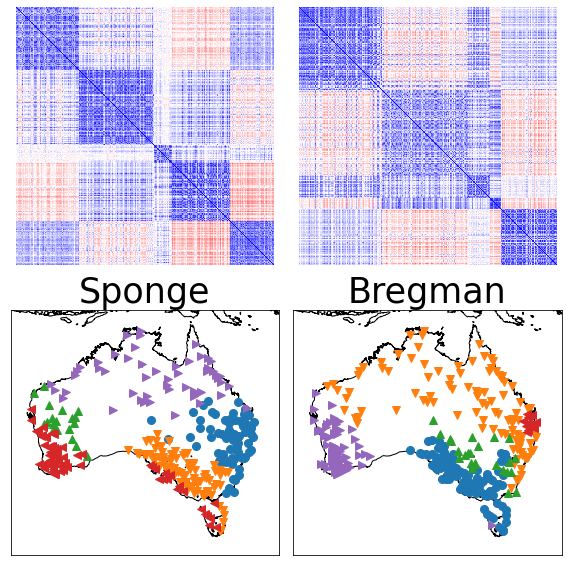

In [10]:
fig, axs = plt.subplots(2, 2,figsize=(8, 8))
axs[0, 0].matshow(ssortedp-ssortedn,cmap='bwr_r',vmin=-1,vmax=1)
axs[0, 0].axis('off')
axs[0, 1].matshow(ssortedp2-ssortedn2,cmap='bwr_r',vmin=-1,vmax=1)
axs[0, 1].axis('off')

#Second line
axs[1, 0].set_title("Sponge",fontsize=35)
grouped_coords = []
for i in range(k):
    i_stations = stations_a[predictions==i]
    i_coords = []
    for s in i_stations:
        idx = np.where(stat_lat_lon_a[:,0] == s)
        i_coords.append(stat_lat_lon_a[idx])
    grouped_coords.append(i_coords)
mm = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',ax=axs[1,0])
# Draw coastlines and fill continents and water with color
mm.drawcoastlines()
colors = ['r', 'g', 'b', 'c', 'y']
markers = []
for i in range(k):
    coords = np.array(grouped_coords[i])[:, 0, 1:3]
    x,y = mm(coords[:,1],coords[:,0])
    mm.plot(x,y, color = cmap(i), markersize=8, lw = 0, marker = markers_[i])
    
axs[1, 1].set_title('Bregman',fontsize=35)
grouped_coords = []
for i in range(k):
    i_stations = stations_a[predictions2==i]
    i_coords = []
    for s in i_stations:
        idx = np.where(stat_lat_lon_a[:,0] == s)
        i_coords.append(stat_lat_lon_a[idx])
    grouped_coords.append(i_coords)
    
mm = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',ax=axs[1,1])

# Draw coastlines and fill continents and water with color
mm.drawcoastlines()
colors = ['r', 'g', 'b', 'c', 'y']
markers = []
for i in range(k):
    coords = np.array(grouped_coords[i])[:, 0, 1:3]
    x,y = mm(coords[:,1],coords[:,0])
    mm.plot(x,y, color = cmap(i), markersize=8, lw = 0, marker = markers_[i])

plt.tight_layout()

In [11]:
rand_score(predictions, predictions2),mutual_info_score(predictions,predictions2)

(0.797599914282653, 0.8342266181930569)

In [3]:
def spectral(A,k):
    #L = nx.linalg.laplacianmatrix.laplacian_matrix(G).toarray()
    L = csgraph.laplacian(A)
    L = L.astype(np.float32)
    vals = vecs = 0
    vals, vecs = eigs(L, k=(k+1), which='SM', maxiter=5000)
    U = np.delete(vecs,np.argmin(vals),1)
    return KMeans(n_clusters=k).fit_predict(U.real)

## Equally spaced distributions

In [4]:
pin=0.1
#pouts = np.arange(pout_min,pout_max,0.01)
pouts=[0.01,0.05,0.1]
sigmas=[0.1,1,10]
with open("metrics.txt",'w',encoding = 'utf-8') as f:
    f.write("pout,sigma,RandIndexBregman,StdRandBregman,MutualInfoBregman,StdMutualBregman,\
    RandIndexKmeans,StdRandKmeans,MutualInfoKmeans,StdMutualKmeans,\
    RandIndexSpectral,StdRandSpectral,MutualInfoSpectral,StdMutualSpectral\n")
    for p_net in pouts:
        P_net = np.eye(3)*pin
        P_net[P_net==0] = p_net
        for sigma in sigmas:
            rs_b = []
            mi_b = []
            rs_k = []
            mi_k = []
            rs_s = []
            mi_s = []
            print(sigma,p_net)
            for _ in range(10):
                G,A,X = generate_benchmark_unit_circle(P_net,c,sigma,n,dim)
                pred_labels = KMeans(n_clusters=c).fit_predict(X)
                rs_k.append(rand_score(true_labels, pred_labels))
                mi_k.append(mutual_info_score(true_labels, pred_labels))
                
                pred_labels = spectral(A,c)
                rs_s.append(rand_score(true_labels, pred_labels))
                mi_s.append(mutual_info_score(true_labels, pred_labels))
                
                A = torch.tensor(A,dtype=torch.float32)
                X = torch.tensor(X,dtype=torch.float32)
                classifier = BregmanClustering(norm=2,matrix_norm=False,method='hard')
                W,B,mu=classifier.cluster(A,X,c,maxiter=100,threshold=5)
                pred_labels = np.argmax(W, axis=1)
                rs_b.append(rand_score(true_labels, pred_labels))
                mi_b.append(mutual_info_score(true_labels, pred_labels))
            f.write(f"{p_net},{sigma},{np.mean(rs_b)},{np.std(rs_b)},{np.mean(mi_b)},{np.std(mi_b)}\
            ,{np.mean(rs_k)},{np.std(rs_k)},{np.mean(mi_k)},{np.std(mi_k)}\
            ,{np.mean(rs_s)},{np.std(rs_s)},{np.mean(mi_s)},{np.std(mi_s)}\n")

0.1 0.01
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
1 0.01
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
10 0.01
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments have converged
point assignments h

In [5]:
df = pd.read_csv("metrics.txt")

,pout,sigma,RandIndexBregman,StdRandBregman,MutualInfoBregman,StdMutualBregman,RandIndexKmeans,StdRandKmeans,MutualInfoKmeans,StdMutualKmeans,RandIndexSpectral,StdRandSpectral,MutualInfoSpectral,StdMutualSpectral
0,0.01,0.1,0.972272,0.083184,1.052402,0.138629,0.994247,0.004446,1.074770,0.018515,0.995563,2.220446e-16,1.079912,1.216188e-16
1,0.01,1.0,0.920007,0.036285,0.840793,0.105472,0.686203,0.023476,0.285943,0.049415,0.995563,2.220446e-16,1.079912,1.857758e-16
2,0.01,10.0,0.567378,0.005864,0.034622,0.012847,0.568339,0.006852,0.036179,0.015323,0.995563,2.220446e-16,1.079912,1.570092e-16
3,0.05,0.1,0.937648,0.102408,0.944310,0.217409,0.991166,0.005574,1.063073,0.022619,0.335585,0.000000e+00,0.007335,0.000000e+00
4,0.05,1.0,0.698907,0.048712,0.320873,0.095108,0.676308,0.028014,0.272504,0.048328,0.335585,0.000000e+00,0.007335,0.000000e+00
5,0.05,10.0,0.566540,0.004335,0.032005,0.009300,0.568049,0.003346,0.035328,0.008251,0.335585,0.000000e+00,0.007335,0.000000e+00
6,0.10,0.1,0.909730,0.123255,0.885744,0.265049,0.992477,0.005938,1.067749,0.023588,0.335585,0.000000e+00,0.007335,0.000000e+00
7,0.10,1.0,0.674796,0.025660,0.263891,0.044827,0.683570,0.025075,0.279688,0.045949,0.335585,0.000000e+00,0.007335,0.000000e+00
8,0.10,10.0,0.569168,0.007812,0.036256,0.017696,0.567608,0.007261,0.034746,0.018382,0.335585,0.000000e+00,0.007335,0.000000e+00
